# Probabilistic Modelling using the Infinite Mixture Model

In many applications it is desirable to allow the model to adjust its complexity to the amount the data. Consider for example the task of assigning objects into clusters or groups. This task often involves the specification of the number of groups. However, often times it is not known beforehand how many groups exist. Moreover, in some applictions, e.g. modelling topics in text documents or grouping species, the number of examples per group is heavy tailed. This makes it impossible to predefine the number of groups and requiring the model to form new groups when data points from previously unseen groups are observed.

A natural approach for such applications is the use of non-parametric models. This tutorial will introduce how to use the Dirichlet process in a mixture of infinitely many Gaussians using Turing. For further information on Bayesian nonparametrics and the Dirichlet process we refer to the [introduction by Zoubin Ghahramani](http://mlg.eng.cam.ac.uk/pub/pdf/Gha12.pdf) and the book "Fundamentals of Nonparametric Bayesian Inference" by Subhashis Ghosal and Aad van der Vaart.

In [1]:
using Turing

## Mixture Model

Before introducing infinite mixture models in Turing, we will briefly review the construction of finite mixture models. Subsequently, we will define how to use the [Chinese restaurant process](https://en.wikipedia.org/wiki/Chinese_restaurant_process) construction of a Dirichlet process for non-parametric clustering.

#### Two-Component Model

First, consider the simple case of a mixture model with two Gaussian components with fixed covariance. 
The generative process of such a model can be written as:

$$
\begin{align}
\pi_1 &\sim Beta(a, b) \\
\pi_2 &= 1-\pi_1 \\
\mu_1 &\sim Normal(\mu_0, \Sigma_0) \\
\mu_2 &\sim Normal(\mu_0, \Sigma_0) \\
z_i &\sim Categorical(\pi_1, \pi_2) \\
x_i &\sim Normal(\mu_{z_i}, \Sigma)
\end{align}
$$

where $\pi_1, \pi_2$ are the mixing weights of the mixture model, i.e. $\pi_1 + \pi_2 = 1$, and $z_i$ is a latent assignment of the observation $x_i$ to a component (Gaussian).

We can implement this model in Turing for 1D data as follows:

In [2]:
@model two_model(x) = begin
    
    # Hyper-parameters
    μ0 = 0.0
    σ0 = 1.0
    
    # Draw weights.
    π1 ~ Beta(1,1)
    π2 = 1-π1
    
    # Draw locations of the components.
    μ1 ~ Normal(μ0, σ0)
    μ2 ~ Normal(μ0, σ0)
    
    # Draw latent assignment.
    z ~ Categorical([π1, π2])
    
    # Draw observation from selected component.
    if z == 1
        x ~ Normal(μ1, 1.0)
    else
        x ~ Normal(μ2, 1.0)
    end
end

##two_model#362 (generic function with 2 methods)

#### Finite Mixture Model

If we have more than two components, this model can elegantly be extend using a Dirichlet distribution as prior for the mixing weights $\pi_1, \dots, \pi_K$. Note that the Dirichlet distribution is the multivariate generalization of the beta distribution. The resulting model can be written as:

$$
\begin{align}
(\pi_1, \dots, \pi_K) &\sim Dirichlet(K, \alpha) \\
\mu_k &\sim Normal(\mu_0, \Sigma_0), \;\; \forall k \\
z &\sim Categorical(\pi_1, \dots, \pi_K) \\
x &\sim Normal(\mu_z, \Sigma) 
\end{align}
$$

which resembles the model in the [Gaussian mixture model tutorial](https://turing.ml/dev/tutorials/1-gaussianmixturemodel/) with a slightly different notation.

## Infinite Mixture Model

The question now arises, is there a generalization of a Dirichlet distribution for which the dimensionality $K$ is infinite, i.e. $K = \infty$?

But first, to implement an infinite Gaussian mixture model in Turing, we first need to load the `Turing.RandomMeasures` module. `RandomMeasures` contains a variety of tools useful in nonparametrics.

In [3]:
using Turing.RandomMeasures

We now will utilize the fact that one can integrate out the mixing weights in a Gaussian mixture model allowing us to arrive at the Chinese restaurant process construction. See Carl E. Rasmussen: [The Infinite Gaussian Mixture Model](https://www.seas.harvard.edu/courses/cs281/papers/rasmussen-1999a.pdf), NIPS (2000) for details.

In fact, if the mixing weights are integrated out, the conditional prior for the latent variable $z$ is given by:

$$ 
p(z_i = k \mid z_{\not i}, \alpha) = \frac{n_k + \alpha/K}{N - 1 + \alpha}
$$

where $z_{\not i}$ are the latent assignments of all observations except observation $i$. Note that we use $n_k$ to denote the number of observations at component $k$ excluding observation $i$. The parameter $\alpha$ is the concentration parameter of the Dirichlet distribution used as prior over the mixing weights.

#### Chinese Restaurant Process

To obtain the Chinese restaurant process construction, we can now derive the conditional prior if $K \rightarrow \infty$.

For $n_k > 0$ we obtain:

$$
p(z_i = k \mid z_{\not i}, \alpha) = \frac{n_k}{N - 1 + \alpha}
$$

and for all infinitely many clusters that are empty (combined) we get:

$$
p(z_i = k \mid z_{\not i}, \alpha) = \frac{\alpha}{N - 1 + \alpha}
$$


Those equations show that the conditional prior for component assignments is proportional to the number of such observations, meaning that the Chinese restaurant process has a rich get richer property.

To get a better understanding of this property, we can plot the cluster choosen by for each new observation drawn from the conditional prior.

In [4]:
# Concentration parameter.
α = 10.0

# Random measure, e.g. Dirichlet process.
rpm = DirichletProcess(α)

# Cluster assignments for each observation.
z = Vector{Int}()

# Maximum number of observations we observe.
Nmax = 500

for i in 1:Nmax
    # Number of observations per cluster.
    K = isempty(z) ? 0 : maximum(z)
    nk = Vector{Int}(map(k -> sum(z .== k), 1:K))
    
    # Draw new assignment.
    push!(z, rand(ChineseRestaurantProcess(rpm, nk)))
end

In [5]:
using Plots

# Plot the cluster assignments over time 
@gif for i in 1:Nmax
    scatter(collect(1:i), z[1:i], markersize = 2, xlabel = "observation (i)", ylabel = "cluster (k)", legend = false)
end;

┌ Info: Saved animation to 
│   fn = /home/cameron/code/TuringTutorials/tmp.gif
└ @ Plots /home/cameron/.julia/packages/Plots/cc8wh/src/animation.jl:98


![tmp](https://user-images.githubusercontent.com/422990/55284032-90cfa980-5323-11e9-8a99-f9315db170cb.gif)

Further, we can see that the number of clusters is logarithmic in the number of observations and data points. This is a side-effect of the "rich-get-richer" phenomenon, i.e. we expect large clusters and thus the number of clusters has to be smaller than the number of observations.

$$
E[K \mid N] \approx \alpha \cdot log \big(1 + \frac{N}{\alpha}\big)
$$

We can see from the equation that the concentration parameter $\alpha$ allows us to control the number of clusters formed *a priori*.

In Turing we can implement an infinite Gaussian mixture model using the Chinese restaurant process construction of a Dirichlet process as follows:

In [6]:
@model infiniteGMM(x) = begin
    
    # Hyper-parameters, i.e. concentration parameter and parameters of H.
    α = 1.0
    μ0 = 0.0
    σ0 = 1.0
    
    # Define random measure, e.g. Dirichlet process.
    rpm = DirichletProcess(α)
    
    # Define the base distribution, i.e. expected value of the Dirichlet process.
    H = Normal(μ0, σ0)
    
    # Latent assignment.
    z = tzeros(Int, length(x))
        
    # Locations of the infinitely many clusters.
    μ = tzeros(Float64, 0)
    
    for i in 1:length(x)
        
        # Number of clusters.
        K = maximum(z)
        nk = Vector{Int}(map(k -> sum(z .== k), 1:K))

        # Draw the latent assignment.
        z[i] ~ ChineseRestaurantProcess(rpm, nk)
        
        # Create a new cluster?
        if z[i] > K
            push!(μ, 0.0)

            # Draw location of new cluster.
            μ[z[i]] ~ H
        end
                
        # Draw observation.
        x[i] ~ Normal(μ[z[i]], 1.0)
    end
end

##infiniteGMM#903 (generic function with 2 methods)

We can now use Turing to infer the assignments of some data points. First, we will create some random data that comes from three clusters, with means of 0, -5, and 10.

In [7]:
using Plots, Random

# Generate some test data.
Random.seed!(1)
data = vcat(randn(10), randn(10) .- 5, randn(10) .+ 10)
data .-= mean(data)
data /= std(data);

Next, we'll sample from our posterior using SMC.

In [8]:
# MCMC sampling
Random.seed!(2)
iterations = 1000
model_fun = infiniteGMM(data);
chain = sample(model_fun, SMC(), iterations);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Finally, we can plot the number of clusters in each sample.

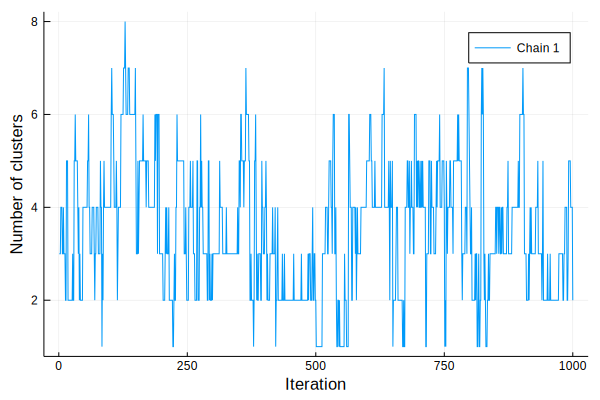

In [9]:
# Extract the number of clusters for each sample of the Markov chain.
k = map(t -> length(unique(chain[:z].value[t,:,:])), 1:iterations);

# Visualize the number of clusters.
plot(k, xlabel = "Iteration", ylabel = "Number of clusters", label = "Chain 1")

If we visualize the histogram of the number of clusters sampled from our posterior, we observe that the model seems to prefer 3 clusters, which is the true number of clusters. Note that the number of clusters in a Dirichlet process mixture model is not limited a priori and will grow to infinity with probability one. However, if conditioned on data the posterior will concentrate on a finite number of clusters enforcing the resulting model to have a finite amount of clusters. It is, however, not given that the posterior of a Dirichlet process Gaussian mixture model converges to the true number of clusters, given that data comes from a finite mixture model. See Jeffrey Miller and Matthew Harrison: [A simple example of Dirichlet process mixture inconsitency for the number of components](https://arxiv.org/pdf/1301.2708.pdf) for details.

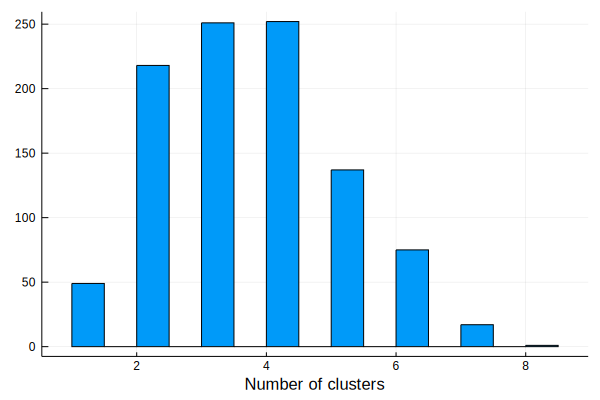

In [10]:
histogram(k, xlabel = "Number of clusters", legend = false)

One issue with the Chinese restaurant process construction is that the number of latent parameters we need to sample scales with the number of observations. It may be desirable to use alternative constructions in certain cases. Alternative methods of constructing a Dirichlet process can be employed via the following representations:

Size-Biased Sampling Process

$$
j_k \sim Beta(1, \alpha) * surplus
$$

Stick-Breaking Process
$$
v_k \sim Beta(1, \alpha)
$$

Chinese Restaurant Process
$$
p(z_n = k | z_{1:n-1}) \propto \begin{cases} 
        \frac{m_k}{n-1+\alpha}, \text{ if } m_k > 0\\\
        \frac{\alpha}{n-1+\alpha}
    \end{cases}
$$

For more details see [this article](https://www.stats.ox.ac.uk/~teh/research/npbayes/Teh2010a.pdf).